In [1]:
import cv2
import numpy as np
import scipy as sp
from PIL import Image
from scipy.ndimage.measurements import label
from skimage.measure import regionprops
from skimage import data
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from matplotlib import patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import xml.etree.ElementTree as ET
import os
import time
import pandas as pd

In [2]:
def normalization(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

def energy_point_game(bbox, saliency_map): # GT 부분의 활성화 값 / 전체 활성화 값
  x1, y1, x2, y2 = bbox
  w, h = saliency_map.shape
  
  empty = np.zeros((w, h))
  empty[y1:y2, x1:x2] = 1
  mask_bbox = saliency_map * empty  
  
  energy_bbox =  mask_bbox.sum()
  energy_whole = saliency_map.sum()
  proportion = energy_bbox / energy_whole
  
  return proportion

def get_label(xml):
  p_size = xml.find('size')
  p_box = xml.find('object').find('bndbox')
  size = {'width':int(p_size.find('width').text),'height': int(p_size.find('height').text)}
  box = {'xmin':int(p_box.find('xmin').text), 'ymin' : int(p_box.find('ymin').text),'xmax': int(p_box.find('xmax').text),'ymax': int(p_box.find('ymax').text)}
  xmin, ymin, xmax, ymax = box['xmin'] / size['width'] * 224, box['ymin'] / size['height'] * 224, box['xmax'] / size['width'] * 224,box['ymax'] / size['height'] * 224
  w, h = xmax - xmin, ymax - ymin
  return {'xmin':xmin, 'ymin':ymin, 'xmax':xmax,'ymax':ymax,'w':w, 'h':h}

def ostu_binary(x):
    thr = filters.threshold_otsu(x)
    binary = x > thr
    return np.multiply(binary, 255)

def IoU(boxA, boxB):
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def generate_bbox(saliency_map, threshold):
    labeled, nr_objects = label(saliency_map > threshold)
    props = regionprops(labeled)
    
    init = props[0].bbox_area
    bbox = tuple(props[0].bbox)
    for b in props:
      if init < b.bbox_area:
          init = b.bbox_area
          bbox = tuple(b.bbox)

    return bbox

In [3]:
class SISE():
    def __init__(self, model, model_name, img_path, class_idx) -> None:
        self.model = model
        self.input_size = model.input_shape[1:3]
        self.model_name = model_name
        self.feature_maps = {}
        self.avg_grads = {}
        self.img = Image.open(img_path).resize((224, 224))
        img_arr = np.asarray(self.img)[:, :, :3] / 255.
        self.input_img = np.expand_dims(img_arr, 0)
        self.class_idx = class_idx
        self.filtered_feature_maps = {}
        self.postprocessed_feature_maps = {}
        self.layer_visualization_maps = {}
        self.total_reduction_rate = 0
        self.result = None
        self.group_bbox = {}
    
    def feature_extractor(self):
        if self.model_name=='vgg16':
            # Feature map을 추출할 layer 결정
            block = [1, 4, 8, 12, 16]
            outputs = [self.model.layers[i].output for i in block]
            feature_map_extraction_model = Model([self.model.inputs], outputs)

            # Layer별 feature map 추출
            feature_maps = {}
            feature_maps_list = feature_map_extraction_model.predict(self.input_img)

            for i, fmap in enumerate(feature_maps_list):
                feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

            self.feature_maps = feature_maps

        elif self.model_name=='resnet50':
            # Feature map을 추출할 layer 결정
            block = [2, 38, 80, 142, 174]
            outputs = [self.model.layers[i].output for i in block]
            feature_map_extraction_model = Model([self.model.inputs], outputs)

            # Layer별 feature map 추출
            feature_maps = {}
            feature_maps_list = feature_map_extraction_model.predict(self.input_img)

            for i, fmap in enumerate(feature_maps_list):
                feature_maps[f'conv{i}'] = tf.convert_to_tensor(np.squeeze(fmap))

            self.feature_maps = feature_maps

        else:
            print('Not support')

    def feature_filtering(self):
        if self.model_name == 'vgg16':
            # conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
            block = [1, 4, 8, 12, 16, 18]
            outputs = [self.model.layers[i].output for i in block]

            grad_model = Model([self.model.inputs], outputs)

            with tf.GradientTape(persistent=True) as tape:
                *conv_outputs, pred = grad_model(self.input_img)
                class_channel = pred[:, self.class_idx]

            grads = {}
            for i, conv in enumerate(conv_outputs):
                grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

            # 피쳐맵의 평균 gradient 계산
            avg_grads = {}
            for k, v in grads.items():
                avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

            self.avg_grads = avg_grads

            # 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
            filtered_feature_maps = {}
            for k, v in avg_grads.items():
                transpose = tf.transpose(self.feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
                filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

            # 필터링 된 피쳐맵 수 비교
            sum1 = sum2 = 0
            for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
                # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
                sum1 += len(k1)
                sum2 += k2.shape[-1]

            # print('\nTotal')
            # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

            self.filtered_feature_maps = filtered_feature_maps
            self.total_reduction_rate = (sum2-sum1)/sum1*100

        elif self.model_name == 'resnet50':
            # conv layer별 피쳐맵과 confidence score(softmax 값)의 gradient 계산
            block = [2, 38, 80, 142, 174, 176]
            outputs = [self.model.layers[i].output for i in block]

            grad_model = Model([self.model.inputs], outputs)

            with tf.GradientTape(persistent=True) as tape:
                *conv_outputs, pred = grad_model(self.input_img)
                class_channel = pred[:, self.class_idx]

            grads = {}
            for i, conv in enumerate(conv_outputs):
                grads[f'conv{i}'] = tape.gradient(class_channel, conv)[0]

            # 피쳐맵의 평균 gradient 계산
            avg_grads = {}
            for k, v in grads.items():
                avg_grads[k] = tf.reduce_mean(v, axis=(0,1))

            self.avg_grads = avg_grads

            # 피쳐맵의 평균 gradient가 0이 넘는 피쳐맵만 필터링
            filtered_feature_maps = {}
            for k, v in avg_grads.items():
                transpose = tf.transpose(self.feature_maps[k], perm=[2,0,1])[v>0] # 필터링 용이를 위해 transpose
                filtered_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

            # 필터링 된 피쳐맵 수 비교
            sum1 = sum2 = 0
            for k1, k2 in zip(avg_grads.values(), filtered_feature_maps.values()):
                # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
                sum1 += len(k1)
                sum2 += k2.shape[-1]

            # print('\nTotal')
            # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')

            self.filtered_feature_maps = filtered_feature_maps
            self.total_reduction_rate = (sum2-sum1)/sum1*100
        
        else:
            print('Not support')
            
    def postprocess(self):
        # Bilinear interpolation
        postprocessed_feature_maps = {}
        for k in self.filtered_feature_maps.keys():
            for i in range(0, self.filtered_feature_maps[k].shape[2], 512):
                # i+512가 array.shape[2]보다 크거나 같으면, 슬라이싱할 수 없습니다.
                # 이 경우, array[:, :, i:]를 슬라이싱합니다.
                if i+512 >= self.filtered_feature_maps[k].shape[2]:
                    if k in postprocessed_feature_maps:
                        try:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)), axis=2)
                        except Exception:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], np.expand_dims(cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR), 2)), axis=2)
                    else:
                        postprocessed_feature_maps[k] = cv2.resize(self.filtered_feature_maps[k][:, :, i:].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)
                else:
                    if k in postprocessed_feature_maps:
                        try:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)), axis=2)
                        except Exception:
                            postprocessed_feature_maps[k] = np.concatenate((postprocessed_feature_maps[k], np.expand_dims(cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR), 2)), axis=2)
                    else:
                        postprocessed_feature_maps[k] = cv2.resize(self.filtered_feature_maps[k][:, :, i:i+512].numpy(), (224,224), interpolation=cv2.INTER_LINEAR)

            for i in range(postprocessed_feature_maps[k].shape[-1]):
                if np.max(postprocessed_feature_maps[k][:,:,i]) == 0.0:
                    continue
                postprocessed_feature_maps[k][:,:,i] = (postprocessed_feature_maps[k][:,:,i] - np.min(postprocessed_feature_maps[k][:,:,i]))/(np.max(postprocessed_feature_maps[k][:,:,i])-np.min(postprocessed_feature_maps[k][:,:,i]))

        self.postprocessed_feature_maps = postprocessed_feature_maps
    
    def filtering_zero_feature_maps(self):
        # Calculate sum of all feature maps
        sum_featurempas = {}
        for k, v in self.filtered_feature_maps.items():
            sum_featurempas[k] = tf.reduce_sum(v, axis=(0,1))

        # Sum of all feature maps != 0 filtering
        not_zero_feature_maps = {}
        for k, v in sum_featurempas.items():
            transpose = tf.transpose(self.filtered_feature_maps[k], perm=[2,0,1])[v!=0] # 필터링 용이를 위해 transpose
            not_zero_feature_maps[k] = tf.transpose(transpose, perm=[1,2,0]) # transpose 다시 되돌리기

        self.filtered_feature_maps = not_zero_feature_maps

    def attribution_masks_compress(self):
        layers = ['conv3', 'conv4']

        layer_bbox = {}

        # conv3, conv4 레이어의 feature map들 bbox 좌표 계산
        for layer in layers:
            layer_bbox[layer] = []
            for index in range(self.postprocessed_feature_maps[layer].shape[2]):
                binary = ostu_binary(self.postprocessed_feature_maps[layer][:,:,index])
                labeled, nr_objects = label(binary > 0)
                props = regionprops(labeled)

                init = props[0].bbox_area
                bbox = tuple(props[0].bbox)
                for b in props:
                    if init < b.bbox_area:
                        init = b.bbox_area
                        bbox = tuple(b.bbox)

                layer_bbox[layer].append(bbox)

        # IoU가 0.5 이상인 feature map끼리 grouping
        group_bbox = {}
        for k in layer_bbox.keys():
            temp = layer_bbox[k].copy()
            group_bbox[k] = []
            for i in range(len(temp)):
                if temp[i] == 0:
                    continue
                temp_group = [i]
                for j in range(i+1, len(temp)):
                    if temp[j] == 0:
                        continue
                    if IoU(temp[i], temp[j]) >= 0.5:
                        temp_group.append(j)
                        temp[j] = 0
                temp[i] = 0
                group_bbox[k].append(temp_group)

        self.group_bbox = group_bbox

        compressed_feature_maps = {}

        for layer in layers:
            for b in group_bbox[layer]:
                compressed_feature_map = np.zeros_like(self.postprocessed_feature_maps[layer][:,:,0].shape)
                for i, feature_map_index in enumerate(b):
                    if i == 0:
                        compressed_feature_map = self.postprocessed_feature_maps[layer][:,:, feature_map_index]
                    else:
                        compressed_feature_map += self.postprocessed_feature_maps[layer][:,:, feature_map_index]

                if layer in compressed_feature_maps:
                    compressed_feature_maps[layer] = np.concatenate((compressed_feature_maps[layer], np.expand_dims(normalization(compressed_feature_map), axis=2)), axis=2)
                else:
                    compressed_feature_maps[layer] = np.expand_dims(normalization(compressed_feature_map), axis=2)

            self.postprocessed_feature_maps[layer] = compressed_feature_maps[layer]

        # 필터링 된 피쳐맵 수 비교
        sum1 = sum2 = 0
        for k1, k2 in zip(self.avg_grads.values(), self.postprocessed_feature_maps.values()):
            # print(f'{len(k1)} -> {k2.shape[-1]}, {len(k1)-k2.shape[-1]}개 감소 (감소율: {(k2.shape[-1]-len(k1))/len(k1)*100}%)')
            sum1 += len(k1)
            sum2 += k2.shape[-1]

        # print('\nTotal')
        # print(f'{sum1} -> {sum2}, {sum1-sum2}개 감소 (감소율: {(sum2-sum1)/sum1*100}%)')
        self.total_reduction_rate = (sum2-sum1)/sum1*100


    def generate_layer_visualization_map(self):
        layer_visualization_maps = {}
        for k in self.postprocessed_feature_maps.keys():
            masks = np.expand_dims(tf.transpose(self.postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
            masked = self.input_img*masks
            preds = self.model.predict(masked)
            layer_visualization_maps[k] = preds.T.dot(masks.reshape(masks.shape[0],-1)).reshape(-1, 224,224)

        self.layer_visualization_maps = layer_visualization_maps

    def layers_fusion(self):
        result = normalization(self.layer_visualization_maps['conv0'][self.class_idx]).copy()

        for k in self.layer_visualization_maps.keys():
            if k == 'conv0':
                continue
            result += self.layer_visualization_maps[k][self.class_idx]
            thr = filters.threshold_otsu(normalization(self.layer_visualization_maps[k][self.class_idx]))
            binary = normalization(self.layer_visualization_maps[k][self.class_idx]) > thr
            binary = np.multiply(binary, 255)
            result = result * binary

        self.result = result

In [4]:
model = load_model('model/resnet50_voc2007')

In [13]:
# AC-SISE
ac_sise = SISE(model, 'resnet50', '000258.jpg', 11)
ac_sise.feature_extractor()
ac_sise.feature_filtering()
ac_sise.filtering_zero_feature_maps()
ac_sise.postprocess()
ac_sise.attribution_masks_compress()
ac_sise.generate_layer_visualization_map()
ac_sise.layers_fusion()

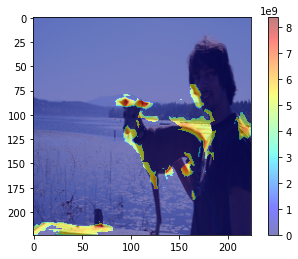

In [14]:
# AC-SISE
plt.imshow(ac_sise.img)
plt.imshow(ac_sise.result, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

In [15]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [16]:
label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'

ebpg_result = list()
iou_result = list()
elapsed_time_list = list()
total_reduction_rate_list = list()

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):    
        tree = ET.parse(f'{label_path}/{annotation.replace(".jpg", ".xml")}')
        root = tree.getroot()
        anno_bbox = get_label(root)

        ac_sise = SISE(model, 'vgg16', f'{test_data_path}/{class_name}/{annotation}', class_index)
        ac_sise.feature_extractor()
        ac_sise.feature_filtering()
        ac_sise.filtering_zero_feature_maps()
        ac_sise.postprocess()
        ac_sise.attribution_masks_compress()
        start = time.time()
        ac_sise.generate_layer_visualization_map()
        ac_sise.layers_fusion()
        end = time.time()
        
        ebpg_result.append(energy_point_game((round(anno_bbox['xmin']), round(anno_bbox['ymin']), round(anno_bbox['xmax']), round(anno_bbox['ymax'])), ac_sise.result))
        bbox = generate_bbox(normalization(ac_sise.result), 0.2)
        iou_result.append(IoU(bbox, (round(anno_bbox['ymin']), round(anno_bbox['xmin']), round(anno_bbox['ymax']), round(anno_bbox['xmax']))))
        elapsed_time_list.append(end-start)
        total_reduction_rate_list.append(ac_sise.total_reduction_rate)


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


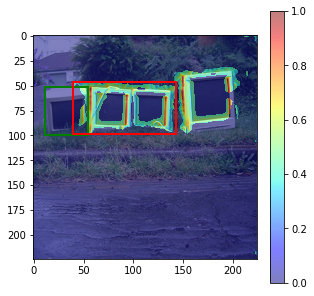

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(ac_sise.img)
plt.imshow(normalization(ac_sise.result), cmap='jet', alpha=0.5)
plt.colorbar()
ax = plt.gca()
rect1 = patches.Rectangle((anno_bbox['xmin'], anno_bbox['ymin']), anno_bbox['w'], anno_bbox['h'], linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((bbox[1], bbox[0]), (bbox[3]-bbox[1]), (bbox[2]-bbox[0]), linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [18]:
print('Mean EBPG:', sum(ebpg_result)/len(ebpg_result))
print('Mean IoU:', sum(iou_result)/len(iou_result))
print('Mean elapsed time:', sum(elapsed_time_list)/len(elapsed_time_list))
print('Mean total reduction rate:', sum(total_reduction_rate_list)/len(total_reduction_rate_list))

Mean EBPG: 0.4554925574952149
Mean IoU: 0.1342492989790967
Mean elapsed time: 1.7451807170252172
Mean total reduction rate: -67.33872342667982


In [19]:
df = pd.DataFrame({'ebpg result':ebpg_result, 'iou result':iou_result, 'elapsed time list':elapsed_time_list, 'total reduction rate list': total_reduction_rate_list})

In [20]:
df.to_excel(excel_writer='AC_SISE_vgg16_0110.xlsx')

In [5]:
classese = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13,
 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

label_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/Annotations'
test_data_path = 'D:/dataset/PASCAL_VOC_2007/VOC2007/test'
img_name_list = []

for class_name, class_index in classese.items():
    print(class_name)
    for annotation in os.listdir(f'{test_data_path}/{class_name}'):
        img_name_list.append((class_name, annotation))


aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor


('car', '002271.jpg')


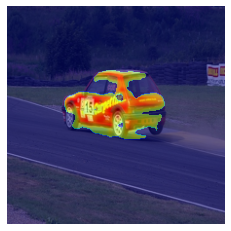

In [7]:
idx = 1441
print(img_name_list[idx])
test = SISE(model, 'resnet50', f'D:/dataset/PASCAL_VOC_2007/VOC2007/test/{img_name_list[idx][0]}/{img_name_list[idx][1]}', classese[img_name_list[idx][0]])
test.feature_extractor()
test.feature_filtering()
test.filtering_zero_feature_maps()
test.postprocess()
# test.attribution_masks_compress()
test.generate_layer_visualization_map()
test.layers_fusion()

plt.imshow(test.img)
plt.imshow(test.result, cmap='jet', alpha=0.5)
# plt.colorbar()
plt.axis('off')
plt.show()

In [23]:
temp_bbox = []
for index in [404]:
    binary = ostu_binary(test.postprocessed_feature_maps['conv3'][:,:,index])
    labeled, nr_objects = label(binary > 0)
    props = regionprops(labeled)

    init = props[0].bbox_area
    bbox = tuple(props[0].bbox)
    for b in props:
        if init < b.bbox_area:
            init = b.bbox_area
            bbox = tuple(b.bbox)

    temp_bbox.append(bbox)

In [24]:
temp_bbox

[(155, 22, 224, 224)]

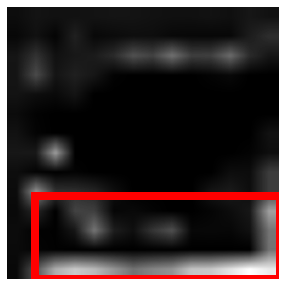

In [25]:
for bbox, index in zip(temp_bbox, [404]):
    plt.figure(figsize=(5,5))
    plt.imshow(test.postprocessed_feature_maps['conv3'][:,:,index], cmap='gray')
    # plt.imshow(result, cmap='jet', alpha=0.5)
#     plt.colorbar()
    ax = plt.gca()
    rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3]-bbox[1], bbox[2]-bbox[0], linewidth=8, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()